In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
#Segment the activity into avalanche duration.
def findQuiesence(raster, q_thresh=0, delta=0):
    first = True
    no_act = []
    thresh = q_thresh
    for i in range(raster.shape[1]):#along column space (i.e. per time step)
        tstep = raster[:,i]#get the spikes for this time step
        if sum(tstep) <= thresh and first:
            curr_quiet = [i]
            first = False
        elif sum(tstep) > thresh and not first:
            if (i - 1) != curr_quiet[0]:#if the quiet period is longer than one time step
                curr_quiet.append(i-1)#append end step of quiesence
            no_act.append(curr_quiet)#add the current quiet period to the list of all quiet periods
            first = True#tell the loop that the next quiet time step is the start of a quiescence period
        
        elif (not first) and (i == raster.shape[1]-1):
            curr_quiet.append(i+1)#append end step of quiesence
            no_act.append(curr_quiet)#add the current quiet period to the list of all quiet periods
    
    avas = []
    if len(no_act) > 1:
        for itr in range(len(no_act) - 1):
            #if the first instance of quiesence is not the first entry, then
            #add an avalanche period starting form t0 and running to the first
            #instance of quiesence
            if itr == 0 and no_act[itr][0] != 0:
                avas.append([0, no_act[itr][0]-1])
            else:
                curr = no_act[itr]
                next = no_act[itr+1]
                end_q = curr[-1]#end of quiescence is last entry
                start_q = next[0]#start of next quiescent period is first entry of next
                
                if (start_q - end_q) > delta:
                    avas.append([end_q+1, start_q-1])  

        if no_act[itr + 1][-1] < raster.shape[1]:
            avas.append([no_act[itr + 1][-1]+1, raster.shape[1]])

    elif len(no_act) == 1:
        if no_act[0][0] != 0:#if the start of no activity is not the first entry
            avas.append([0, no_act[0][0]-1])
        if no_act[0][-1]+1 < raster.shape[1]:
            avas.append([no_act[0][-1]+1, raster.shape[1]])
        

    return no_act, avas

Bernoulli Model

In [29]:
#bernoulli network
class BernoulliRNN():
    def __init__(self,
                 Ndim,
                 c,
                 alpha_max,
                 sigma,
                 p_hid,
                 p_spont=0.0,
                 ):

        super(BernoulliRNN, self).__init__()
        self.p_spont = p_spont
        self.p_hid = p_hid
        self.N = Ndim
        self.c = c
        self.alpha_max = alpha_max
        self.sigma=sigma#sigma can be a scalar or an array of length d as well if branching parameter is not global

        #initialize weight matrix
        self.W = self.initDirichlet(self.N, self.c, self.alpha_max, self.sigma)

        #initialize activity matrix
        self.H = self.initHidden()

    #N x N nodes, that can be randomly connected with up to C other neurons
    #constrain the sum of probabilities such that a global branching parameter controls all sigmas, i.e. the probabilities of any set of projections
    #must sum to sigma_i = sigma_global.
    #each connection i to j has a probability of propagating pij between 0 and 1
    #branching parameter 0 < sigma_i < C where sigma_i is equivalent to the expected number of descendants an active unit i produces. 
    def initDirichlet(self, dim, c, alpha_max, sigma):
        alphas = np.random.uniform(0.0,alpha_max,c)#dirichlet alphas params list.
        D = np.random.dirichlet(alphas,size=dim)*sigma#scale entries of D by sigma s.t. the branching parameter controls sum of pij's for a given node
        W = np.zeros((dim, dim))
        inds = np.arange(dim)
        for i in range(W.shape[0]):
            conn_inds = np.random.choice(inds, size=c, replace=False, p=None)
            W[i, conn_inds] = D [i, :]

        assert all(np.isclose(np.sum(W[r,:]), sigma) for r in range(W.shape[0]))#check that all rows of W sum to sigma
        return W

    def initHidden(self):
        H = np.random.choice([0, 1], size=(self.N,1), p=[1-self.p_hid, self.p_hid])
        # H = np.zeros((self.N,1))
        # ind = np.random.choice(range(len(H)), size=1)
        # H[ind] = 1.0
        return H


    #unit j at t + 1 becomes active only if unit i at t is active (1) and the connection transmits if rand uniformly distrubted number [0, 1]
    #is less than equal to pij of that connection
    def forward(self):
        spont_mask = np.random.choice([0, 1], size=(self.N,1), p=[1-self.p_spont, self.p_spont])#mask of spontaneous activity
        p_transmit = np.random.uniform(0.0,1.0,(self.N, self.N))#matrix of transmit probabilities to compare to weight matrix
        transmit_mask = self.W >= p_transmit#create boolean mask indicating which synapses transmit this time step
        self.H = np.clip(self.H + spont_mask, a_min=0.0, a_max=1.0)#nodes may be spontaneously active with a probability of p_spont. add the spontaneous activity mask to the current hidden state and clip to be less than 1.
        self.H = np.clip(transmit_mask @ self.H, a_min=0.0, a_max=1.0)#update hidden state (NxN)(Nx1) = (Nx1) then clip to be less than 1


In [30]:
#Model parameters
Ndim = 100#number of nodes
c=10#number of connections per node
alpha_max=10#dirichlet connectivity distribution parameter
sigma=1.0#branching parameter
p_hid=1/Ndim#distribution of on/off in activity initialization
p_spont=0.001#probability of spontaneous activity at each time step

#initialize model
model = BernoulliRNN(Ndim, c, alpha_max, sigma, p_hid, p_spont=p_spont)

#run model
tmax = 100000#number of time steps
t = 0
Hs = []
while t <= tmax:
    Hs.append(model.H)
    model.forward()
    t+= 1
Hs = np.stack(Hs)

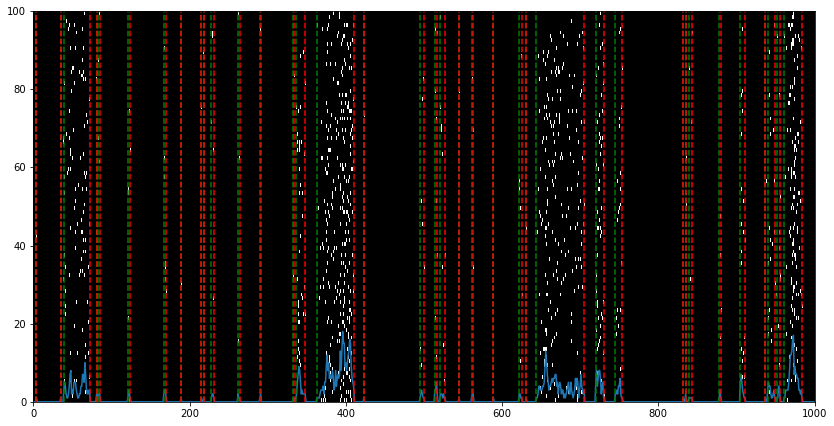

In [31]:
import matplotlib as mpl
def moving_average(a, n=3):
    a_padded = np.pad(a, (n//2, n-1-n//2), mode='edge')
    return np.convolve(a_padded, np.ones((n,))/n, mode='valid')


#plot raster
Hs_plot = Hs.squeeze().T[:,:1000]

no_act, avas = findQuiesence(Hs_plot)
durs = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        durs.append(ava[1]-ava[0])
    else:
        durs.append(1)
thresh=0
counts = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        tot_act = (Hs_plot[:,ava[0]:ava[1]] > thresh).sum()
        counts.append(tot_act)
    else:
        counts.append((Hs_plot[:,ava[0]]> thresh).sum())


# ax = sns.heatmap(Hs_plot[:,:1000])

# ax.plot(moving_average(np.mean(Hs_plot, axis=0), n=200)[:1000])
# plt.show()

fig, ax = plt.subplots(figsize=(14,20))

# define the colors
cmap = mpl.colors.ListedColormap(['k', 'w'])

# create a normalize object the describes the limits of
# each color
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# plot it
ax.imshow(Hs_plot, interpolation='none', cmap=cmap, norm=norm, extent=[0,Hs_plot.shape[1],0,Hs_plot.shape[0]], aspect=5)
ax.plot(np.sum(Hs_plot, axis=0))
for e in avas:
    ax.axvline(e[0], c='g', ls='--')
    ax.axvline(e[1], c='r', ls='--')
plt.show()
    

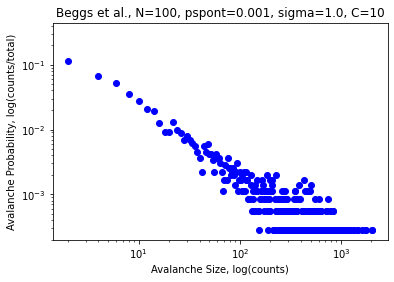

In [7]:
no_act, avas = findQuiesence(Hs_plot)
durs = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        durs.append(ava[1]-ava[0])
    else:
        durs.append(1)
thresh=0
counts = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        tot_act = (Hs_plot[:,ava[0]:ava[1]] > thresh).sum()
        counts.append(tot_act)
    else:
        counts.append((Hs_plot[:,ava[0]]> thresh).sum())


binwidth = 2
bins=range(min(counts), max(counts) + binwidth, binwidth)
hist, bin_edges = np.histogram(counts ,bins=bins)

fig, ax = plt.subplots()
ax.loglog(bin_edges[:-1], hist/sum(hist), 'bo')
ax.set_xlabel("Avalanche Size, log(counts)")
ax.set_ylabel("Avalanche Probability, log(counts/total)")
ax.set_title('Beggs et al., N=' + str(Ndim) + ', pspont=' + str(p_spont) + ', sigma=' + str(sigma) + ', C=' + str(c))
# ax.scatter(bin_edges[:-1], hist, c='blue', edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()


Heaviside Model

In [7]:
#build markov model
import torch
import numpy as np
import torch.nn as nn

class HeavisideRNN():
    def __init__(self,
                 Ndim,
                 c,
                 scale,
                 alpha,
                 diag,
                 device = 'cpu',
                 h_type = 'discrete'
                 ):

        super(HeavisideRNN, self).__init__()
        self.N = Ndim
        self.c = c
        self.diag = diag
        self.alpha = alpha
        self.scale = scale
        self.device = device
        self.h_type = h_type

        #initialize weight matrix
        # self.W = self.initNormColumn()
        self.W = self.makeConnectivity()

        # #initialize activity matrix
        # self.H = self.init_hidden()

        #initialize state matrix (0, 1) for on/off
        self.S = self.init_state()
    
    def makeOrthogonalMatrix(self, normal=False):
        from scipy.stats import ortho_group
        m = ortho_group.rvs(dim=self.N)
        if normal:
            return m.dot(m.T)
        return m

    def makeSparseDiagonal(self, s=1):
        from scipy.sparse import diags
        diagonals = np.random.uniform(low=0.0, high=1.0, size=self.N)*s
        d = diags(diagonals).toarray()
        return d

    #connectivity matrix procedure as described in Benayoun et al. 2010
    def makeConnectivity(self):
        conn = self.initNormColumn()
        return conn

    #N x N nodes, that can be randomly connected with up to C other neurons
    def initNormColumn(self):
        #need to ensure that a single column of the weight matrix does not end up with only
        #zeros as entries, this will cause the normalization to return NaNs. Accomplish this
        #with the while condition s.t. the loop repeats and creats another weight matrix
        #if ANY column of weights sums to zero.
        A = np.zeros((self.N, self.N))
        while len(np.where(np.sum(A, axis=0) == 0)[0]) > 0:
            A = np.zeros((self.N, self.N))
            inds = np.arange(self.N)

            for i in range(A.shape[0]):
                if self.diag:
                    conn_inds = np.random.choice(inds, size=self.c, replace=False, p=None)
                else:
                    conn_inds = np.random.choice(np.delete(inds, i), size=self.c, replace=False, p=None)

                A[i, conn_inds] = np.random.uniform(0.,1.,self.c)

        A = self.scale*A/np.sum(A, axis=0)#divide each column by its sum to constrain the weights to sum to 1.
        assert np.isclose(self.N*scale, np.sum(np.sum(A, axis=0)))#asserts that the sum down zero axis for each column is 1.
        return torch.from_numpy(A).type(torch.FloatTensor)

    def init_state(self):
        """Initialize on/off state of RNN."""
        # A = torch.zeros((2*self.N,1))
        # rand_on = torch.randint(0, 2*self.N, (1,))
        # A [rand_on,:] = 1
        # return A.type(torch.FloatTensor).to(self.device)
        return torch.reshape(torch.multinomial(torch.tensor([0.5, 0.5]), num_samples=self.N, replacement=True), (self.N,1)).type(torch.FloatTensor).to(self.device)
        # return gain*torch.randn(self.n_layers, batch_size, self.hidden_dim).to(self.device)
        # return gain*torch.ones(self.n_layers, batch_size, self.hidden_dim).to(self.device)


    def tanh(self, x, s=2):
        t= (np.exp(s*x)-1)/(np.exp(s*x)+1)
        return t

    #heaviside activation function
    def heaviside(self, x, values=None):
        if values != None:
            assert (len(values) == len(x))
        else:
            values = torch.zeros_like(torch.flatten(x))
        
        x_shape = tuple(list(x.size()))
        out = torch.zeros_like(torch.flatten(x))
        for i, entry in enumerate(torch.flatten(x)):
            if entry >= values[i]:
                out[i] = 1.

        return torch.reshape(out, x_shape)

    def forward(self, b):
        H = self.W @ self.S + b # step the continuous hidden state values
        if self.h_type == 'analog':
            shapes = torch.rand(H.shape)*self.alpha
            self.S = torch.clamp(self.tanh(H, shapes),min=0.0) # for nodes that are off, get probability of turning on by passing hidden state through hyperbolic tan
        else:
            threshs = torch.rand(H.shape)*self.alpha
            self.S = self.heaviside(H, threshs) # for nodes that are off, get probability of turning on by passing hidden state through hyperbolic tan




In [8]:
#Model parameters
Ndim = 100#number of nodes
c=10#number of connections per node
alpha=1.0#threshold noise scale
scale=1.0#synaptic weight strength normalization

#initialize model
model = HeavisideRNN(Ndim, c, scale, alpha, diag=False)
                 

tmax = 1000#number of time steps
t = 0
Ss = [torch.clone(model.S)]
for t in range(tmax):
    b = torch.zeros(size=(Ndim, 1))#no noisey bias
    model.forward(b)
    Ss.append(torch.clone(model.S))
    
Ss = torch.stack(Ss)


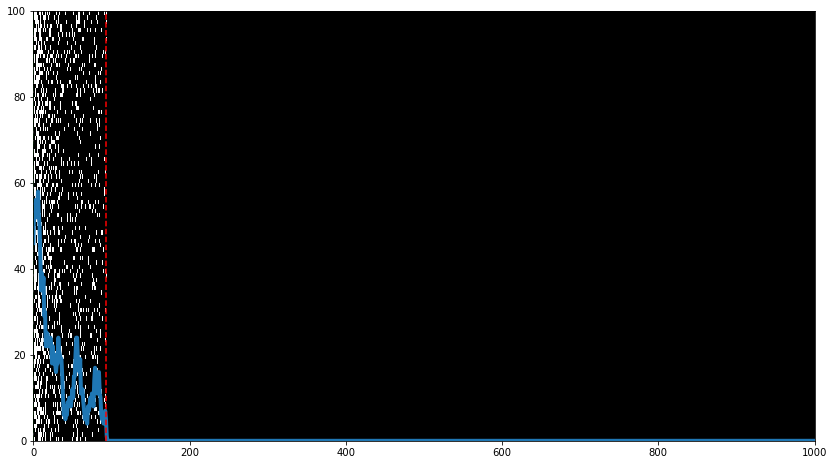

In [26]:
#plot raster
import seaborn as sns
import matplotlib.pyplot as plt
Ss_plot = Ss.squeeze().T[:,:1000]


states = Ss_plot.numpy()
import matplotlib as mpl
def moving_average(a, n=3):
    a_padded = np.pad(a, (n//2, n-1-n//2), mode='edge')
    return np.convolve(a_padded, np.ones((n,))/n, mode='valid')

no_act, avas = findQuiesence(states, q_thresh=2, delta=10)
durs = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        durs.append(ava[1]-ava[0])
    else:
        durs.append(1)
thresh=0
counts = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        tot_act = (Ss_plot[:,ava[0]:ava[1]] > thresh).sum()
        counts.append(tot_act)
    else:
        counts.append((Ss_plot[:,ava[0]]> thresh).sum())


# ax = sns.heatmap(Hs_plot[:,:1000])

# ax.plot(moving_average(np.mean(Hs_plot, axis=0), n=200)[:1000])
# plt.show()

fig, ax = plt.subplots(figsize=(14,20))

# define the colors
cmap = mpl.colors.ListedColormap(['k', 'w'])

# create a normalize object the describes the limits of
# each color
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# plot it
ax.imshow(states, interpolation='none', cmap=cmap, norm=norm, extent=[0,states.shape[1],0,states.shape[0]], aspect=5.5)
ax.plot(np.sum(states, axis=0),lw=4)
for e in avas:
    ax.axvline(e[0], c='g', ls='--')
    ax.axvline(e[1], c='r', ls='--')
plt.show()
    

In [ ]:
iters = 1000
tmax = 1000 #let the network run for 10000 time steps
durs = []
counts = []
#Model parameters
c=10#number of connections per node
alpha=1.0#threshold noise scale
scale=1.0#synaptic weight strength normalization
Ns = [50, 100, 200, 400, 800, 1600]
res_dict = {}
for Ndim in Ns:
    for i in range(iters):
        #initialize model
        model = HeavisideRNN(Ndim, c, scale, alpha, diag=False)
                        
        tmax = 1000#number of time steps
        t = 0
        Ss = [torch.clone(model.S)]
        for t in range(tmax):
            b = torch.ones(size=(2*Ndim, 1))*h#torch.normal(0.0, 0.01, size=(2*Ndim, 1))
            model.forward(b)
            Ss.append(torch.clone(model.S))
            
        Ss = torch.stack(Ss)
        states = Ss_plot.numpy()
        # ax = sns.heatmap(states[:,:1000])
        # plt.show()
        no_act, avas = findQuiesence(states, q_thresh=50, delta=10)

        for ava in avas:#for each avalanch period
            if len(ava)>1:
                durs.append(ava[1]-ava[0])
            else:
                durs.append(1)

        thresh=0

        for ava in avas:#for each avalanch period
            if len(ava)>1:
                tot_act = (states[ava[0]:ava[1],:] > thresh).sum()
                counts.append(tot_act)
            else:
                counts.append((states[ava[0]]> thresh).sum())

    res_dict[Ndim] = {'durs': durs, 'counts':counts}


Markov model

In [ ]:
#build markov model
import torch
import numpy as np
import torch.nn as nn

class MarkovRNN():
    def __init__(self,
                 Ndim,
                 c,
                 scale,
                 alpha,
                 w0,
                 wsyn,
                 conn_style,
                 diag=False,
                 device = 'cpu'
                 ):

        super(MarkovRNN, self).__init__()
        self.N = Ndim
        self.c = c
        self.diag = diag
        self.alpha = alpha
        self.scale = scale
        self.device = device
        self.conn_style = conn_style
        self.w0 = w0
        self.wsyn = wsyn
        #initialize weight matrix
        # self.W = self.initNormColumn()
        self.W = self.makeConnectivity()

        # #initialize activity matrix
        # self.H = self.init_hidden()

        #initialize state matrix (0, 1) for on/off
        self.S = self.init_state()
    
    def makeOrthogonalMatrix(self, normal=False):
        from scipy.stats import ortho_group
        m = ortho_group.rvs(dim=self.N)
        if normal:
            return m.dot(m.T)
        return m

    def makeSparseDiagonal(self, s=1):
        from scipy.sparse import diags
        diagonals = np.random.uniform(low=0.0, high=1.0, size=self.N)*s
        d = diags(diagonals).toarray()
        return d

    #connectivity matrix procedure as described in Benayoun et al. 2010
    def makeConnectivity(self):
        if self.conn_style == 'sparse':
            M_delta = self.makeOrthogonalMatrix()
            M_sigma = self.makeOrthogonalMatrix()
            G_delta = self.makeSparseDiagonal(s=self.scale)
            G_sigma = self.makeSparseDiagonal()

            EminusI = np.linalg.inv(M_delta) @ G_delta @ M_delta
            EplusI = np.linalg.inv(M_sigma) @ G_sigma @ M_sigma

            W_I = (EplusI - EminusI)/2
            W_E = (EplusI + EminusI)/2

            #remove negative values
            W_I[W_I < 0] = 0
            W_E[W_E < 0] = 0

            #ok now we have to scale the inhibitory synaptic strength for all inhibitory synapses

            #and scale the excitatory syanptic strength for all excitatory synapses

            conn = np.empty((2*self.N, 2*self.N))
            conn[:self.N,:self.N] = W_E
            conn[self.N:,:self.N] = W_E
            conn[:self.N,self.N:] = -W_I
            conn[self.N:,self.N:] = -W_I
            conn = torch.from_numpy(conn).type(torch.FloatTensor)

        elif self.conn_style == 'all':
            i_mag = (self.wsyn - self.w0)/2 
            e_mag = (self.wsyn + self.w0)/2
            W_E = np.ones((self.N, self.N))*(e_mag/self.N)
            W_I = np.ones((self.N, self.N))*(i_mag/self.N)
            conn = np.empty((2*self.N, 2*self.N))
            conn[:self.N,:self.N] = W_E
            conn[self.N:,:self.N] = W_E
            conn[:self.N,self.N:] = -W_I
            conn[self.N:,self.N:] = -W_I
            conn = torch.from_numpy(conn).type(torch.FloatTensor)

        else:
            conn = self.initNormColumn()

        return conn

    #N x N nodes, that can be randomly connected with up to C other neurons
    def initNormColumn(self):
        #need to ensure that a single column of the weight matrix does not end up with only
        #zeros as entries, this will cause the normalization to return NaNs. Accomplish this
        #with the while condition s.t. the loop repeats and creats another weight matrix
        #if ANY column of weights sums to zero.
        A = np.zeros((self.N, self.N))
        while len(np.where(np.sum(A, axis=0) == 0)[0]) > 0:
            A = np.zeros((self.N, self.N))
            inds = np.arange(self.N)

            for i in range(A.shape[0]):
                if self.diag:
                    conn_inds = np.random.choice(inds, size=self.c, replace=False, p=None)
                else:
                    conn_inds = np.random.choice(np.delete(inds, i), size=self.c, replace=False, p=None)

                A[i, conn_inds] = np.random.uniform(0.,1.,self.c)

        A = self.scale*A/np.sum(A, axis=0)#divide each column by its sum to constrain the weights to sum to 1.
        assert np.isclose(self.N*scale, np.sum(np.sum(A, axis=0)))#asserts that the sum down zero axis for each column is 1.
        return torch.from_numpy(A).type(torch.FloatTensor)

    def init_state(self):
        """Initialize on/off state of RNN."""
        # A = torch.zeros((2*self.N,1))
        # rand_on = torch.randint(0, 2*self.N, (1,))
        # A [rand_on,:] = 1
        # return A.type(torch.FloatTensor).to(self.device)
        return torch.reshape(torch.multinomial(torch.tensor([0.5, 0.5]), num_samples=2*self.N, replacement=True), (2*self.N,1)).type(torch.FloatTensor).to(self.device)
        # return gain*torch.randn(self.n_layers, batch_size, self.hidden_dim).to(self.device)
        # return gain*torch.ones(self.n_layers, batch_size, self.hidden_dim).to(self.device)

    # def init_hidden(self):
    #     """Initialize hidden state of RNN."""
    #     # return torch.zeros((2*self.N,1)).to(self.device)
    #     return torch.randn(2*self.N, 1).to(self.device)
    #     # return torch.ones(self.N, 1).to(self.device)

    def tanh(self, x, s=2):
        t= (np.exp(s*x)-1)/(np.exp(s*x)+1)
        return t

    def forward(self, b):
        H = self.W @ self.S + b # step the continuous hidden state values
        on_mask = self.S > 0 # get boolean version of on/off status of network nodes
        off_mask = ~on_mask # get inverse mask to inidcate which nodes are off

        if self.S[on_mask].shape[0] > 0:#check if there are any nodes on
            # decay term is whether or not an on node decays to off for this forward step. alpha determines this probability
            decay = torch.multinomial(torch.tensor([1 - self.alpha, self.alpha]), num_samples=self.S[on_mask].shape[0], replacement=True).type(torch.FloatTensor).to(self.device)
            self.S[on_mask] = self.S[on_mask] - decay # subtract decay array (of 1s, turn of, or 0s, keep on)

        p_on = torch.clamp(self.tanh(H),min=0.0) # for nodes that are off, get probability of turning on by passing hidden state through hyperbolic tan
        temp = torch.empty_like(self.S[off_mask]) # create temporary tensory to hold multinomial choices based on tanh probs
        for i in range(temp.shape[0]):# for each node that is off
            #make a multinomial choice with the probability based on the tanh output
            on_off = torch.multinomial(torch.tensor([1 - p_on[i], p_on[i]]), num_samples=1, replacement=True).type(torch.FloatTensor).to(self.device)
            temp[i] = on_off # set the value for this node in the temp array to 1, turn on, or 0, keep off
        self.S[off_mask] = self.S[off_mask] + temp # add the temp array to the state of the network for the neurons that are off



In [9]:
#Model parameters
Ndim = 800#number of nodes
c=10#number of connections per node
alpha=0.1#probability of decaying from on state to off
scale=1.0
w0 = 0.2
wsyn = 1.8
h = 0.001

#initialize model
model = MarkovRNN(Ndim, c, scale, alpha, w0,
                  wsyn, conn_style = 'all')
                 

tmax = 1000#number of time steps
t = 0
Ss = [torch.clone(model.S)]
for t in range(tmax):
    b = torch.ones(size=(2*Ndim, 1))*h#torch.normal(0.0, 0.01, size=(2*Ndim, 1))
    model.forward(b)
    Ss.append(torch.clone(model.S))
    
Ss = torch.stack(Ss)


In [16]:
#plot raster
import seaborn as sns
import matplotlib.pyplot as plt
Ss_plot = Ss.squeeze().T[:,:1000]


states = Ss_plot.numpy()
import matplotlib as mpl
def moving_average(a, n=3):
    a_padded = np.pad(a, (n//2, n-1-n//2), mode='edge')
    return np.convolve(a_padded, np.ones((n,))/n, mode='valid')

no_act, avas = findQuiesence(states, q_thresh=50, delta=10)
durs = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        durs.append(ava[1]-ava[0])
    else:
        durs.append(1)
thresh=0
counts = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        tot_act = (Hs_plot[:,ava[0]:ava[1]] > thresh).sum()
        counts.append(tot_act)
    else:
        counts.append((Hs_plot[:,ava[0]]> thresh).sum())


# ax = sns.heatmap(Hs_plot[:,:1000])

# ax.plot(moving_average(np.mean(Hs_plot, axis=0), n=200)[:1000])
# plt.show()

fig, ax = plt.subplots(figsize=(14,20))

# define the colors
cmap = mpl.colors.ListedColormap(['k', 'w'])

# create a normalize object the describes the limits of
# each color
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# plot it
ax.imshow(states, interpolation='none', cmap=cmap, norm=norm, extent=[0,states.shape[1],0,states.shape[0]], aspect=0.5)
ax.plot(np.sum(states, axis=0),lw=4)
for e in avas:
    ax.axvline(e[0], c='g', ls='--')
    ax.axvline(e[1], c='r', ls='--')
plt.show()
    

NameError: name 'findQuiesence' is not defined

In [13]:
iters = 1000
tmax = 1000 #let the network run for 10000 time steps
durs = []
counts = []
#Model parameters
Ndim = 800#number of nodes
c=10#number of connections per node
alpha=0.1#probability of decaying from on state to off
scale=1.0
w0 = 0.2
wsyn = 0.8
h = 0.001
wsyns = [0.8, 1.8, 13.8]
res_dict = {}
for wsyn in wsyns:
    for i in range(iters):
        #initialize model
        model = MarkovRNN(Ndim, c, scale, alpha, w0,
                        wsyn, conn_style = 'all')
                        
        tmax = 1000#number of time steps
        t = 0
        Ss = [torch.clone(model.S)]
        for t in range(tmax):
            b = torch.ones(size=(2*Ndim, 1))*h#torch.normal(0.0, 0.01, size=(2*Ndim, 1))
            model.forward(b)
            Ss.append(torch.clone(model.S))
            
        Ss = torch.stack(Ss)
        states = Ss_plot.numpy()
        # ax = sns.heatmap(states[:,:1000])
        # plt.show()
        no_act, avas = findQuiesence(states, q_thresh=50, delta=10)

        for ava in avas:#for each avalanch period
            if len(ava)>1:
                durs.append(ava[1]-ava[0])
            else:
                durs.append(1)

        thresh=0

        for ava in avas:#for each avalanch period
            if len(ava)>1:
                tot_act = (states[ava[0]:ava[1],:] > thresh).sum()
                counts.append(tot_act)
            else:
                counts.append((states[ava[0]]> thresh).sum())

    res_dict[wsyn] = {'durs': durs, 'counts':counts}


KeyboardInterrupt: 

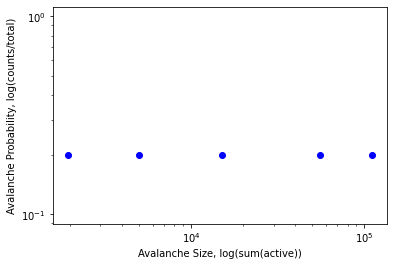

In [16]:
binwidth = 2
# bins=range(min(durs), max(durs) + binwidth, binwidth)
# hist, bin_edges = np.histogram(durs,bins=bins)

bins=range(min(counts), max(counts) + binwidth, binwidth)
hist, bin_edges = np.histogram(counts,bins=bins)

fig, ax = plt.subplots()
ax.loglog(bin_edges[:-1], hist/sum(hist), 'bo')
# ax.set_xlabel("Avalanche Durations, log(time steps)")
ax.set_xlabel("Avalanche Size, log(sum(active))")
ax.set_ylabel("Avalanche Probability, log(counts/total)")
# ax.set_title('Heaviside Avalance Durations, N=' + str(hidden_dim) + ', C=' + str(15))
# ax.set_title('Markov Process Model Avalance Sizes, N=' + str(hidden_dim) + ', C=' + str(15))

# ax.scatter(bin_edges[:-1], hist, c='blue', edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

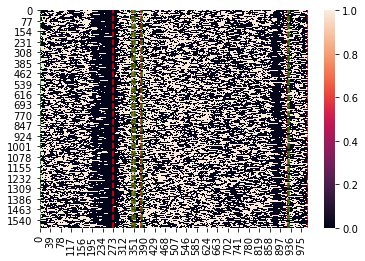

In [20]:
avas
#plot raster
import seaborn as sns
import matplotlib.pyplot as plt
Ss_plot = Ss.squeeze().T
ax = sns.heatmap(Ss_plot[:,:1000])
for e in avas:
    ax.axvline(e[0], c='g', ls='--')
    ax.axvline(e[1], c='r', ls='--')
plt.show()

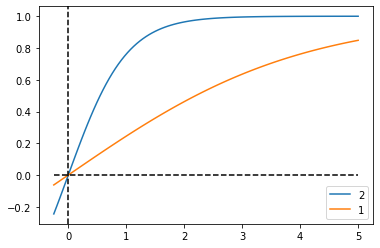

In [16]:
def tanh(x, s=2):
    t= (np.exp(s*x)-1)/(np.exp(s*x)+1)
    return t

#hyperbolic tan manipulation
x = np.linspace(-0.25, 5, 100)
y1 = tanh(x)
alpha = 3
y2 = tanh(x, 0.5)
plt.plot(x, y1, label='2')
plt.plot(x, y2, label='1')
plt.axvline(0, c='k', ls='--')
plt.plot(x, np.zeros(len(x)), c='k', ls='--')
plt.legend()
plt.show()
